In [32]:
import itertools
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, GridSearchCV


# Import the Data

We import two datasets: 'heart' and 'o2Saturation'. Then, these datasets are merged into a single dataframe for further analysis.

In [33]:
heart_file_path = "/Users/anna-alexandradanchenko/Documents/University/Second Year/Data Science/HeartAttackAnalysis/input/heart.csv"
o2_file_path = "/Users/anna-alexandradanchenko/Documents/University/Second Year/Data Science/HeartAttackAnalysis/input/o2Saturation.csv"

df_data = pd.read_csv(heart_file_path)

df_o2 = pd.read_csv(o2_file_path)
df_o2 = df_o2.rename(columns={"98.6": "satlvl"})

df_data["satlvl"] = df_o2["satlvl"]
df_data = df_data.rename(columns={"thalachh": "max_heart_rate", "fbs": "fasting_blsugar", "trtbps": "rest_blpressure"})
df_data.head(10)

,age,sex,cp,rest_blpressure,chol,fasting_blsugar,restecg,max_heart_rate,exng,oldpeak,slp,caa,thall,output,satlvl
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,98.1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,97.5
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,97.5
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,97.5
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,97.5
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1,97.5
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,97.5


# Addressing Missing Data and Duplicate Entries
The analysis of the provided code indicates an absence of missing data and the presence of only a single duplicate entry in the dataset. This finding suggests that additional data cleaning processes may not be required. However, the duplicate entry is removed from the dataset for consistency.

Additionally, for better data handling, the target column 'output' has been repositioned to the final position in the column sequence.

In [34]:
count_nan_in_df = df_data.isnull().sum()
print(count_nan_in_df)

count_duplicates = df_data.duplicated().value_counts()
print(count_duplicates)
df_data.drop_duplicates(keep='first',inplace=True)

column_to_move = 'output'
new_order = [col for col in df_data.columns if col != column_to_move] + [column_to_move]
df_data = df_data[new_order]


age                0
sex                0
cp                 0
rest_blpressure    0
chol               0
fasting_blsugar    0
restecg            0
max_heart_rate     0
exng               0
oldpeak            0
slp                0
caa                0
thall              0
output             0
satlvl             0
dtype: int64
False    302
True       1
Name: count, dtype: int64


# Correlation Evaluation and Feature Selection 
## Examining Variable Correlation with the Target

Let us evaluate the correlation between each feature and the target variable. The presented graph offers an insightful visualization, depicting the correlation coefficients for each variable. This analysis will guide us in feature engeneering process. 

As can be seen from the graph, the "fasting_blsugar" is the feature wich has the least direct impact on the target variable, while "cp" and "exng" have the highest impact. Importantly, there is no direct correlation between the target variable and any of the features, therefore it can be suggested that there is no data leakage. Thus, we can conclude that there is no need to remove any of the features from the dataset.

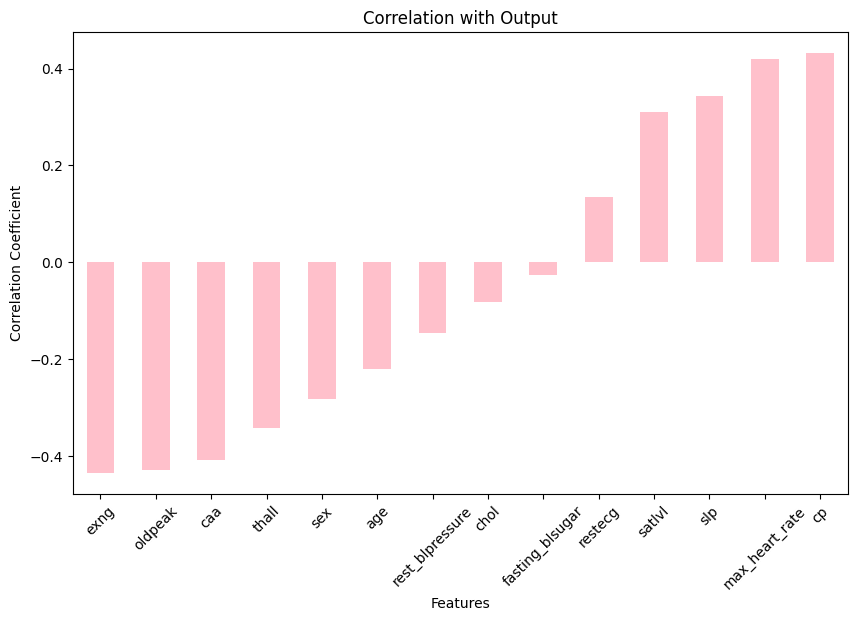

In [35]:
data_corr = df_data.corr()['output'][:-1].sort_values() # -1 means that the latest row is SalePrice
# top_features = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.2
# print("There is {} strongly correlated values with SalePrice:\n{}".format(len(top_features), top_features))

plt.figure(figsize=(10, 6))
data_corr.plot(kind='bar', color='pink')
plt.title('Correlation with Output')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

## Visualization of Correlations: Correlation Matrix

In this part, we construct a correlation matrix to analyze the correlation among the features. The matrix is visualized as a heatmap, offering a clear representation of the correlations.

It is evident from the graph that there is generally no strong correlation between the features, therefore there is no need to drop any of them for now. However, after establishing baseline model, we may consider dropping the "slp" feature, as it has high correlation with "oldpeak" feature and lowest correlation with the target variable from two of them.

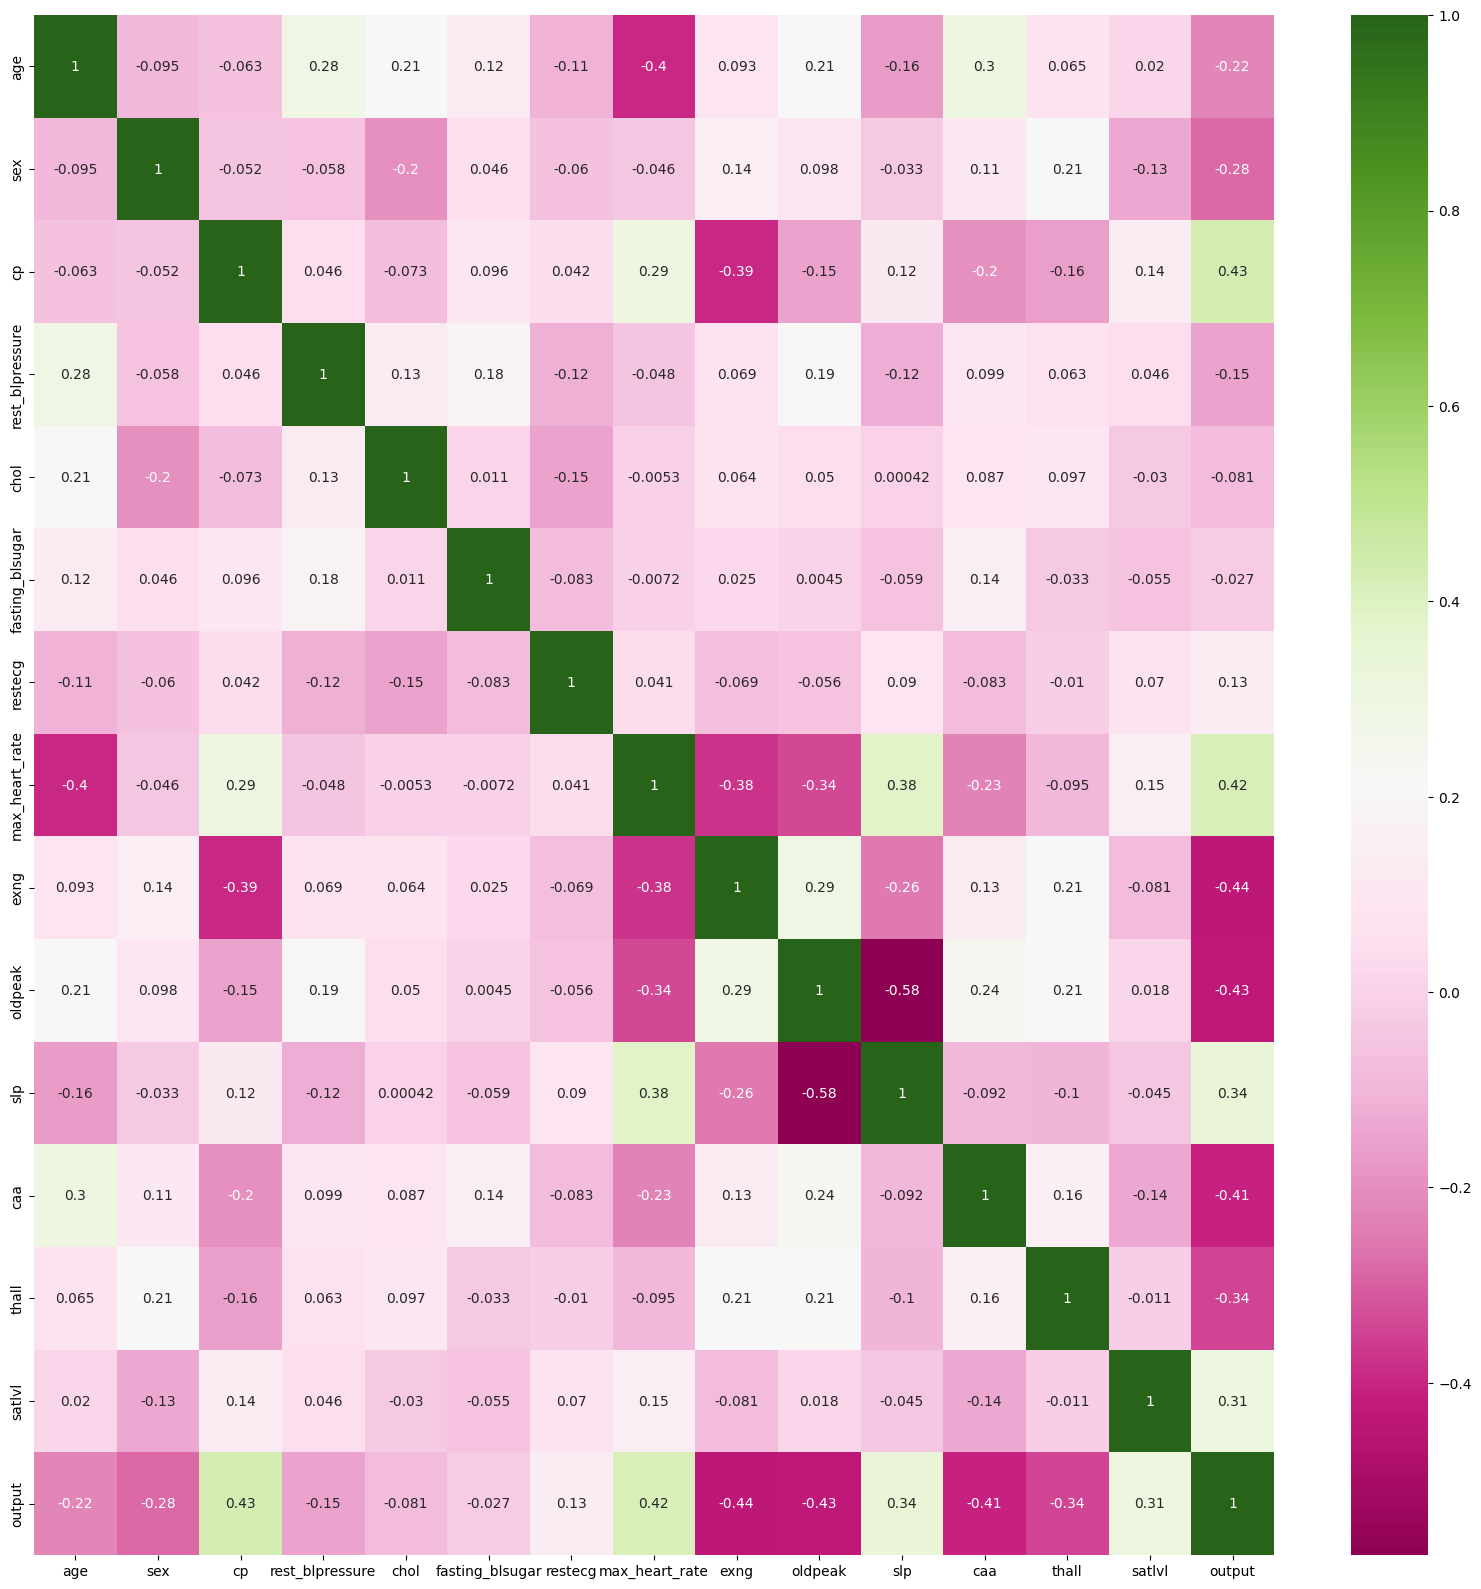

In [36]:
corrMatrix = df_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

# Variables Distribution

Examining the distribution of the variables is an important step in the exploratory data analysis. The presented graphs offer a clear visualization of the distribution of each variable, featuring a box plot for high cardinality features and a bar chart for low cardinality features.

age                 41
sex                  2
cp                   4
rest_blpressure     49
chol               152
fasting_blsugar      2
restecg              3
max_heart_rate      91
exng                 2
oldpeak             40
slp                  3
caa                  5
thall                4
satlvl               7
output               2
dtype: int64
The following columns are low cardinality columns: ['sex', 'cp', 'fasting_blsugar', 'restecg', 'exng', 'slp', 'caa', 'thall', 'satlvl', 'output']


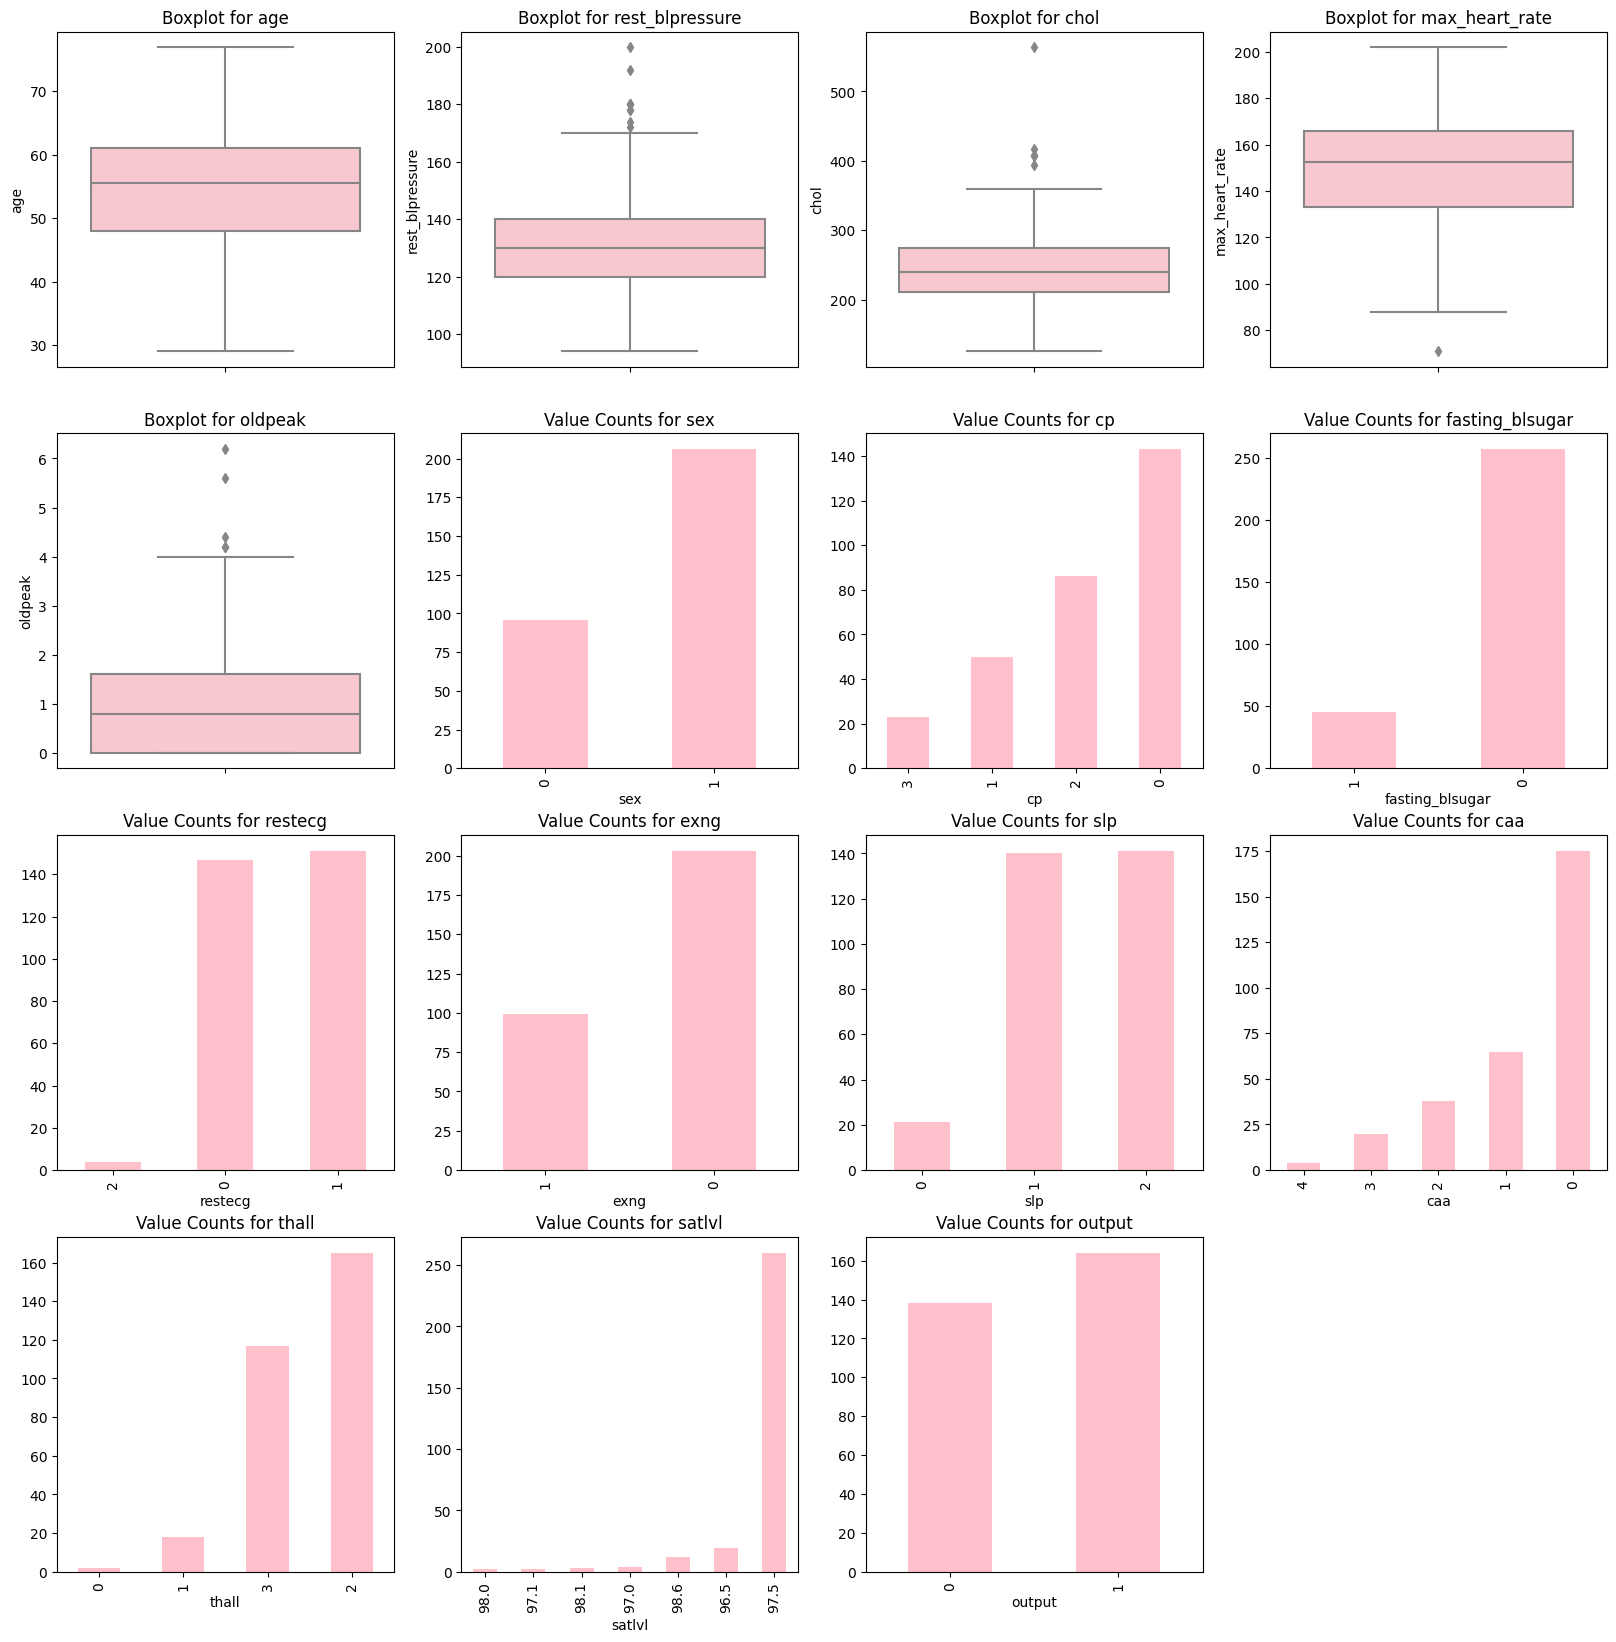

In [37]:
nunique_cnt = df_data.nunique()
print(nunique_cnt)

low_card_cols = nunique_cnt[nunique_cnt < 15].index.tolist()
high_card_cols = nunique_cnt[nunique_cnt >= 15].index.tolist()
print("The following columns are low cardinality columns: " + str(low_card_cols))

# Determine the total number of plots
total_plots = len(high_card_cols) + len(low_card_cols)

# Determine the number of rows and columns on the grid. It outputs integer, as it the numbers should be equal. 
# We choose a square grid that can fit all plots, or a rectangular one that's as close to square as possible
grid_size = int(np.ceil(np.sqrt(total_plots)))
# Create a figure with the grid layout
plt.figure(figsize=(20, 20))

# Plotting high cardinality columns
for i, column in enumerate(high_card_cols):
    plt.subplot(grid_size, grid_size, i + 1)
    sns.boxplot(y=df_data[column], color="pink")
    plt.title(f'Boxplot for {column}')

# Plotting low cardinality columns
for i, column in enumerate(low_card_cols):
    plt.subplot(grid_size, grid_size, i + len(high_card_cols) + 1)
    column_value_counts = df_data[column].value_counts().sort_values()
    column_value_counts.plot(kind='bar', color='pink')
    plt.title(f'Value Counts for {column}')

# Analysis

## Disclaimer

Before starting to analyse data, finding trends and making conclusions, it is important to note that the presented dataset is generated and should be used only in purely educational purposes for data analysis, as it doesn't reflect any kind of real-life medical data. 

## Age and Heart Attack
Now, let's examine the correlation between the age and the output closely.

Typically, we would expect the incidence of heart attacks to increase with age. However, the graph shows two overlapping distributions where the peak incidence of heart attacks ('output 1') seems to occur around 55 years of age, after which it decreases. Conversely, the incidence of no heart attack ('output 0') rapidly increases after this age range, suggesting that in the given dataset, individuals older than 55 are less likely to have had a heart attack compared to those younger. 

This is an unexpected trend since it does not follow the common assumption that the risk of heart attacks continuously increases with age.

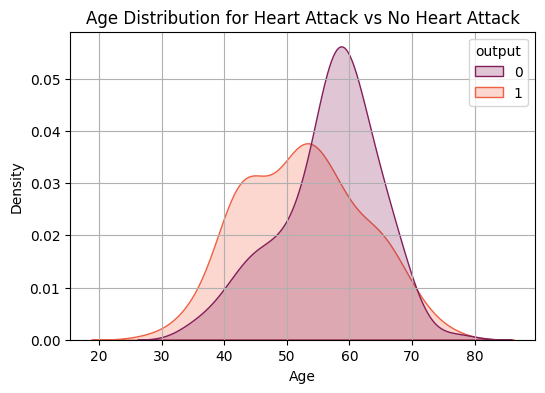

In [38]:
plt.figure(figsize=(6, 4))
# kdeplot basically calculates how common or rare different values of the variable are
sns.kdeplot(data=df_data, x='age', hue='output', fill=True, palette="rocket", common_norm=False)
plt.title('Age Distribution for Heart Attack vs No Heart Attack')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Heart Attach correlaton with Biological Sex
The correlation between sex and heart attack occurrences is the next aspect to examine. 

The distribution graphs above clearly show that the provided data is skewed towards males. Furthermore, the  graph presented below indicates that the male population in the dataset is less likely to experience a heart attack than females. However, there are similar numbers of heart attack occurrences for both sexes. 

However, the data may be skewed, which could lead to a potential misinterpretation of the risks, for instance, if the male population is more likely to visit the ER in case of any symptoms. Therefore, a more in-depth analysis is required to make definitive claims about the risks.

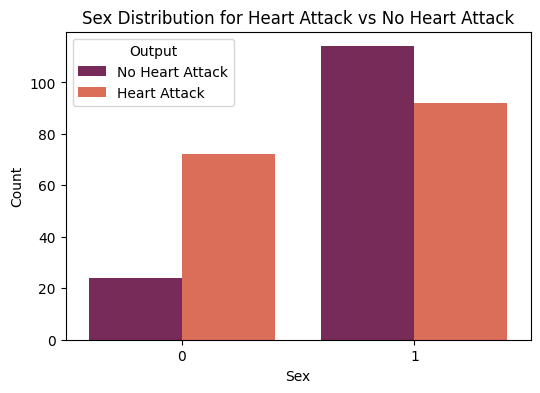

In [39]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_data, x='sex', hue='output', palette="rocket")
plt.title('Sex Distribution for Heart Attack vs No Heart Attack')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Output', labels=['No Heart Attack', 'Heart Attack'])
plt.show()

## Chest Pain Type and Heart Attack
According to the metadata: 
- 0: typical angina
- 1: atypical angina
- 2: non-anginal pain
- 3: asymptomatic

Therefore, it can be concluded that people with non-anginal chest pain are more likely to expirience heart attack, which doesn't reflect real-life data. 

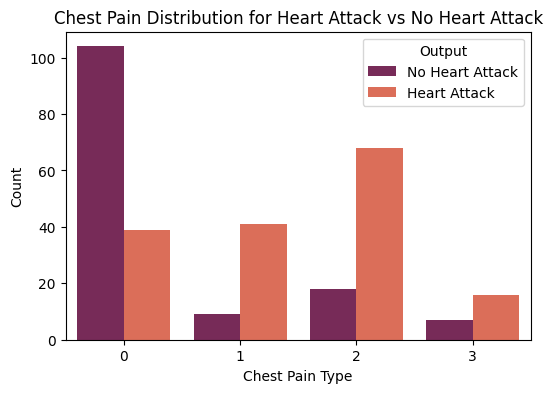

In [40]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_data, x='cp', hue='output', fill=True, palette="rocket")
plt.title('Chest Pain Distribution for Heart Attack vs No Heart Attack')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Output', labels=['No Heart Attack', 'Heart Attack'])
plt.show()

## Heat Attack and ECG Correlation

According to the MetaData: 
- 0: normal
- 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- 2: showing probable or definite left ventricular hypertrophy by Estes' criteria


It can be concluded that the highest risk of the heart attack is present in patients with ST-T wave abnormality. 

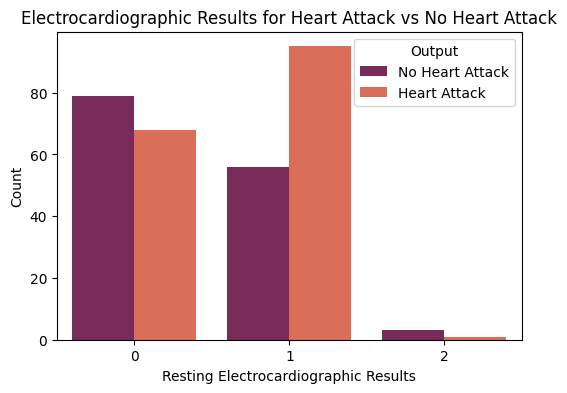

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_data, x='restecg', hue='output', fill=True, palette="rocket")
plt.title('Electrocardiographic Results for Heart Attack vs No Heart Attack')
plt.xlabel('Resting Electrocardiographic Results')
plt.ylabel('Count')
plt.legend(title='Output', labels=['No Heart Attack', 'Heart Attack'])
plt.show()

Now, let's divide the data into features and target variable, X and y accordingly. 

In [42]:
X = df_data.drop("output", axis = 1)
y = df_data["output"]

# Model Development

In this stage, we focus on comparing the performance of various predictive models to establish a baseline. Initially, an array *models* is created to list the models under evaluation. These models are initialized with their default hyperparameters, except for the Logistic Regression model, where the maximum number of iterations is explicitly set to 3000 to ensure convergence.

In [43]:
models = []
models.append(('LR', LogisticRegression(max_iter=3000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

Next, we define a function *performance_score* to compute various performance metrics: accuracy, precision, recall, and F1 score. This function utilizes cross-validation with 5 folds to assess the performance of each model.

In [44]:
def performance_score(X, y, model):

    accuracy_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"Accuracy: {np.mean(accuracy_score):.3f}")

    precision_score = cross_val_score(model, X, y, cv=5, scoring='precision')
    print(f"Precision: {np.mean(precision_score):.3f}")

    recall_score = cross_val_score(model, X, y, cv=5, scoring='recall')
    print(f"Recall: {np.mean(recall_score):.3f}")

    f1_score = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"F1: {np.mean(f1_score):.3f}")

Now, let us evaluate performance scores for each model we chose to test using a loop. 

In [45]:
for name, model in models:
    print(f"{name} scores")
    performance_score(X, y, model)
    print()

LR scores
Accuracy: 0.825
Precision: 0.822
Recall: 0.872
F1: 0.844

KNN scores
Accuracy: 0.642
Precision: 0.656
Recall: 0.720
F1: 0.686

RFC scores
Accuracy: 0.814
Precision: 0.843
Recall: 0.866
F1: 0.829

NB scores
Accuracy: 0.785
Precision: 0.808
Recall: 0.805
F1: 0.803



As can be observed from the output, Logistic Regression model has similar performance to the Random Forest, however, it has the advantage of faster execution. Additionally, the Logistic Regression model performance scores should be better after hyperparameter tuning and feature transformation, therefore it is selected as the preferred choice for further analysis and optimization and as a baseline.

## Further Data and Model Improvements

We begin by applying one-hot encoding to low-cardinality columns in the dataset. As can be seen from the output, the implementation of one-hot encoding has led to improvements in Accuracy, Precision, and F1 scores. 

In [46]:
low_card_cols.remove("satlvl")
low_card_cols.remove("output")

encoded_data = pd.get_dummies(df_data[low_card_cols], columns = low_card_cols, drop_first=False)
encoded_data = encoded_data.astype(int)

df_data.drop(low_card_cols, axis = 1, inplace = True)
df_data = pd.concat([df_data, encoded_data], axis = 1)

X = df_data.drop("output", axis = 1)
y = df_data["output"]

performance_score(X, y, LogisticRegression(max_iter=3000))

Accuracy: 0.844
Precision: 0.850
Recall: 0.872
F1: 0.859


The next step in the data preprocessing pipeline is to normalize the data. The MinMaxScaler scales each feature to a given range, in our case, between 0 and 1. Importantly, the binary features are already in a normalized form, so scaling them is unnecessary and could potentially introduce noise. 

By employing MinMaxScaler, the data is prepared in a way that is more easy for the Logistic Regression algorithm to process, leading to slight improvements in the model's performance metrics.

In [47]:
scaler = MinMaxScaler(feature_range = (0,1))

nunique_cnt_X = X.nunique()
two_value_cols = nunique_cnt_X[nunique_cnt_X == 2].index.tolist()

cols_to_scale = [col for col in X.columns if col not in two_value_cols]

X_scaled = scaler.fit_transform(X[cols_to_scale])
X_scaled_df = pd.DataFrame(X_scaled, columns=cols_to_scale, index=X.index)

X = pd.concat([X.drop(cols_to_scale, axis=1), X_scaled_df], axis=1)

performance_score(X, y, LogisticRegression(max_iter=3000))

Accuracy: 0.851
Precision: 0.858
Recall: 0.872
F1: 0.863


Now, let us address the transformation of certain features identified with outliers, as previously shown in the distribution graphs. We will specifically transform resting blood pressure, cholesterol and max heart rate features using log transformation. It improves the score of the model, even if the improvement is not significant.

In [48]:
X_log = X.copy()

# Add a small constant to avoid log(0
X_log["rest_blpressure"]= np.log(X.rest_blpressure + 0.00001)
X_log["chol"]= np.log(X.chol + 0.00001)
X_log["max_heart_rate"]= np.log(X_log.max_heart_rate + 0.00001)

performance_score(X_log, y, LogisticRegression(max_iter=3000))

X =X_log.copy()

Accuracy: 0.861
Precision: 0.865
Recall: 0.884
F1: 0.873


We will drop the "slp" feature as suggested earlier. The model performance has improved slightly.

In [49]:
X.drop(["slp_0", "slp_1", "slp_2"], axis=1, inplace=True)
performance_score(X, y, LogisticRegression(max_iter=3000))

Accuracy: 0.861
Precision: 0.866
Recall: 0.884
F1: 0.874


### Hyperparameter Tuning using Exhaustive Search

Now, we will try to improve our model by finding the best hyperparameters using GridSearchCV. GridSearchCV is an exhaustive search, however, the run time is 2.8 seconds, as the number of hyperparameters is relatively small. 

In [50]:
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C_new = np.logspace(1, 3, num=100)

# combinations = list(itertools.product(range(1, 5), repeat=2))
# random.shuffle(combinations)
# random_combinations = combinations[:10]
# class_weight_dicts = [{0: combo[0], 1: combo[1]} for combo in random_combinations]

hyperparameters = dict(C=C_new, warm_start=warm_start, solver=solver)

rf_random = GridSearchCV(estimator = LogisticRegression(max_iter=3000), cv=5, param_grid=hyperparameters, n_jobs=-1)
rf_random.fit(X, y)

model_random = rf_random.best_estimator_

performance_score(X, y, model_random)

print(rf_random.best_estimator_)

Accuracy: 0.871
Precision: 0.877
Recall: 0.890
F1: 0.882
LogisticRegression(C=10.0, max_iter=3000, warm_start=True)


## Final Model

In [51]:
model = LogisticRegression(C=10, max_iter=1000, warm_start=True, solver='liblinear')
model.fit(X, y)

performance_score(X, y, model)

Accuracy: 0.871
Precision: 0.877
Recall: 0.890
F1: 0.882


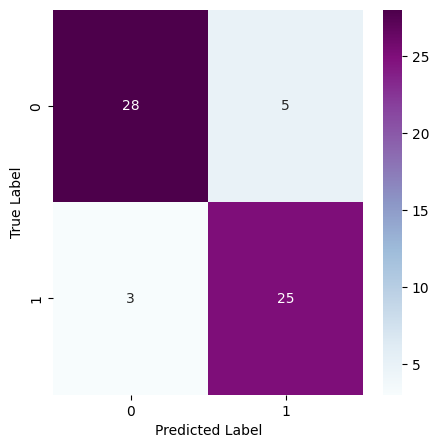

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)


confMat = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(5, 5))

sns.heatmap(confMat, annot=True, cmap="BuPu")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()